# DrivenData: Heart disease prediction using Logistic Regression

###### BY ANNE DE GRAAF

This notebook gives an overview of my model to predict heart disease using the Driven Data heart disease data set.

Prior to writing this notebook I had already evaluated the data set and applied z-score normalization to the numerical data and one-hot encoding to the categorical data (see also "data_processing.py" in this repository).

The final score of my logistic regression model was 0.32931, which is currently 54th place out of 962 on the leaderboard.


In [10]:
# python packages
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

# scikit packages
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.svm import LinearSVC, SVC, SVR

# my own functions
from functions import logLoss

## Loading data

In [3]:
# load (normalized) training data
X = pd.read_csv('../train_values_normalized.csv', index_col=0)
y = pd.read_csv('../train_labels.csv', index_col=0)

# load (normalized) test data
X_test = pd.read_csv('../test_values_normalized.csv', index_col=0)

## First a simple model using the given data
A logistic regression model with L1 regularization. Implementing k-fold cross validation to get an estimate of the performance.

### Stratified k-fold cross-validation (with k=10)

In [5]:
str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
crossVal_performance = np.zeros(str_kFold.get_n_splits())
i=int(0)
for iTrain, iCross in str_kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    model_i = LogisticRegression(penalty='l1', tol=1e-8, solver='liblinear').fit(X_train, np.ravel(y_train))
    prob_i = model_i.predict_proba(X_cross)
    crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
    i+=1
    
print('mean cross-validation performance: %0.5f' %np.mean(crossVal_performance))

mean cross-validation performance: 0.44292


### Fit model on the entire training set

In [7]:
# apply logistic regression on entire training set
logResModel = LogisticRegression(penalty='l2', tol=1e-8, solver='liblinear').fit(X, 
                                                np.ravel(y))

trainProb = logResModel.predict_proba(X)
trainLoss = logLoss(y, trainProb)[0,1]
print('log loss on training set is: %0.5f' %trainLoss)

log loss on training set is: 0.33812


Score on the train set is a lot better than on cross val set, as expected of course. I'm curious to see the performance on the test set. So let's make the predictions and upload the results to DrivenData and find out.

### Evaluate performance on the test set

In [9]:
# loading test data
prob_test = logResModel.predict_proba(X_test)[:,1]

# saving test results
d = {'heart_disease_present': prob_test}
submission_df = pd.DataFrame(data=d, index=X_test.index)
submission_df.to_csv('../logResModel_results.csv')

##### Test set performance: log loss of 0.32931 (54th place out of 962 on the leaderboard on January 3, 2019.)

So how can we improve our performance from hereon?
The performace of our model is measured by the log loss function. This function penalizes lack of confidence; in other words: if we output more extreme probabilities for our correct predictions, our score might get better.

Below I made an SVM model for the same input data, and plotted the results together with the results of the logistic regression.

### SVM with linear kernel

SVM mean cross-validation performance: 1.15213
SVM performance on train set is: 0.88353


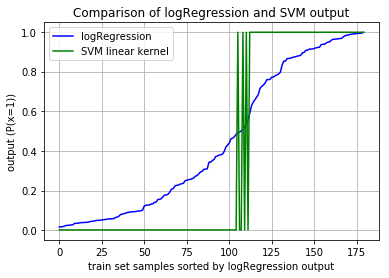

In [12]:
# model parameters
SVM1 = LinearSVC(dual=False, C=1)

# determine performance on crossval set
SVM_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
crossVal_performance = np.zeros(SVM_kFold.get_n_splits())
i=int(0)
for iTrain, iCross in SVM_kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    SVM_model_i = SVM1.fit(X_train, np.ravel(y_train))
    assign_class = SVM_model_i.predict(X_cross)
    class_prob = np.transpose([[0.999 if x==1 else 0.001 for x in assign_class]])  # we can't take log(0)
    crossVal_performance[i] = logLoss(y_cross, class_prob)
    i+=1
print('SVM mean cross-validation performance: %0.5f' %np.mean(crossVal_performance))

# fit on all train data and give performance on train set
svmModel1 = SVM1.fit(X, np.ravel(y))
assign_class = svmModel1.predict(X)
class_prob = np.transpose([[0.999 if x==1 else 0.001 for x in assign_class]])
print('SVM performance on train set is: %0.5f' %logLoss(y, class_prob))

a, b = zip(*sorted(zip(trainProb[:,1], class_prob)))

plt.plot(a, 'blue', label='logRegression')
plt.plot(b, 'green', label='SVM linear kernel')
plt.ylabel('output (P(x=1))')
plt.xlabel('train set samples sorted by logRegression output')
plt.title('Comparison of logRegression and SVM output')
plt.legend(loc='best')
plt.grid(b=1)

I think it's great to see in this graph how the logistic regression compares to SVM. Both algorithms are quite similar in their predictions, but the classification margin of the SVM is really made visible: samples that output low probabilities in logistic regression (say, below 45%) output 0 in the SVM. Samples that output hight probabilities in LR (say, above 65%) output 1 in the SVM. Samples that are in between (so more or less 50:50) can output a 0 or a 1 in SVM.

Even though the graph is great for demonstration, the SVM unfortunately gave a really bad performance because it is not accurate enough.

So I've made my first, crude model and now I want to improve it. First let's add some polynomial features, and then try to make an optimal selection out of those features. And use that in a logistic regression model.

## Polynomial features

In [13]:
# only polynomials of the numerical features are included:
numeric_cols = ['resting_blood_pressure', 'num_major_vessels', 'fasting_blood_sugar_gt_120_mg_per_dl', 
                     'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age', 'max_heart_rate_achieved']

# the rest of the columns are categorical data:
categoric_data = X.copy()
categoric_data.drop(numeric_cols, axis=1, inplace=True)

# make 2nd degree poly features from numerical data
polynomials = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
poly_features = polynomials.fit_transform(X[numeric_cols])

# normalize data to mean=0 and std=1
scaler = StandardScaler(copy=False, with_mean=True, with_std=True).fit(poly_features)
poly_features = scaler.transform(poly_features)
# note: the intercept is here normalized to zero. We correct this further below.

# make data frame with all data
poly_train_df = pd.DataFrame(data=poly_features,
                             index=X.index,
                             columns=polynomials.get_feature_names(numeric_cols))
poly_train_df = poly_train_df.join(categoric_data)
poly_train_df['1'] = 1.0 # intercept was changed to zero by normalization. We have to correct that. 

# make poly df for test set
categoric_test = X_test.copy()
categoric_test.drop(numeric_cols, axis=1, inplace=True)
poly_test = polynomials.fit_transform(X_test[numeric_cols])
poly_test = scaler.transform(poly_test)
poly_test_df = pd.DataFrame(data=poly_test,
                           index=X_test.index,
                           columns=polynomials.get_feature_names(numeric_cols))
poly_test_df = poly_test_df.join(categoric_test)

## Feature selection using the Lasso
First I'm going to try Lasso regularization, which can act as a feature selector to some extend. We'll see how well it performs on our data set. To find the optimal model, we have to tune the hyperparameter C, which is visualized in the graph below.

functions.py:12: RuntimeWarning: divide by zero encountered in log
  J = -1.0/n * ( np.dot( np.transpose(y), np.log(predictions) ) +
functions.py:13: RuntimeWarning: divide by zero encountered in log
  np.dot( np.transpose(ones-y),np.log(ones-predictions) ))


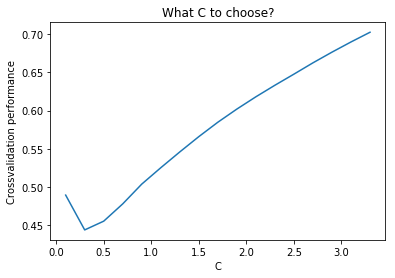

In [14]:
X = poly_train_df
C_list = np.arange(.1, 5.0, .2)
crossVal_loss = np.zeros(len(C_list))

for j in range(len(C_list)):
    str_kFold = StratifiedKFold(n_splits=10, shuffle=False)
    crossVal_performance = np.zeros(str_kFold.get_n_splits())
    logRes_params = LogisticRegression(penalty='l1', C=C_list[j], 
                    fit_intercept=False, tol=1e-8, solver='liblinear', max_iter=300)
    i=int(0)
    for iTrain, iCross in str_kFold.split(X, y):
        X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
        y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
        model_i = logRes_params.fit(X_train, np.ravel(y_train))
        prob_i = model_i.predict_proba(X_cross)
        crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
        i+=1
    crossVal_loss[j] = np.mean(crossVal_performance)

plt.plot(C_list, crossVal_loss)
plt.xlabel('C')
plt.ylabel('Crossvalidation performance')
plt.title('What C to choose?');

I iteratively determined the optimal C to be about 0.30:

In [19]:
# the model with C=0.20:
logRes_params = LogisticRegression(penalty='l1', C=0.30, 
        fit_intercept=False, tol=1e-8, solver='liblinear', max_iter=300)

# performance on crossval set:
str_kFold = StratifiedKFold(n_splits=10, shuffle=False)
crossVal_performance = np.zeros(str_kFold.get_n_splits())
i=int(0)
for iTrain, iCross in str_kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    model_i = logRes_params.fit(X_train, np.ravel(y_train))
    prob_i = model_i.predict_proba(X_cross)
    crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
    i+=1
print('crossval performance: %0.5f' %np.mean(crossVal_performance))

# performance on entire train set:
logRes_fit = logRes_params.fit(X, np.ravel(y))
train_prob = logRes_fit.predict_proba(X)
print('train performance: %0.5f' %logLoss(y, train_prob)[0,1])

crossval performance: 0.44396
train performance: 0.36048


This crossval performance is not my best-yet. Let's see the effects of elastic net.

## Elastic Net
I'm cutting straight to the optimal hyperparams I've found, which gave a crossval performance of 0.43937 (the lowest so far).

In [21]:
# the model with optimal alpha and ratio:
a = 0.025
r = 0.55

elNet_params = SGDClassifier(loss='log', penalty='elasticnet', 
            alpha=a, l1_ratio=r, fit_intercept=False, 
            max_iter=300)

# performance on entire train set:
elNet_fit = elNet_params.fit(X, np.ravel(y))
train_prob = elNet_fit.predict_proba(X)
print('train performance: %0.5f' %logLoss(y, train_prob)[0,1])

# predicting the test set:
test_probab = elNet_fit.predict_proba(poly_test_df)[:,1]

# saving test results
d = {'heart_disease_present': test_probab}
submission_df = pd.DataFrame(data=d, index=poly_test_df.index)
submission_df.to_csv('../elasticNet_a025r55_results.csv')

train performance: 0.35817


This gives a test performance of 0.3719, which is actually worse than my first model. So somehow the crossval performance is not a good prediction of test performance. This can have a number of reasons but I have to find out why exactly this happens...

## Forward Stepwise feature selection (still under construction)

In [ ]:
features = poly_train_df.copy()
selection = pd.DataFrame(data=features['1'], 
                         index=features.index)
features.drop('1', axis=1, inplace=True)
print(len(selection.columns))

while len(selection.columns < 40):
    bestPerformance = 1.0
    for col in features.columns:
        # selection[col] = features[col]
        # fit logres model and give crossval performance
        # if performance < bestPerformance:
        #    bestPerformance = performance
        #    features.drop(col, axis=1, inplace=True)
        # else:
        #    selection.drop(col, axis=1, inplace=True)    
        
        
        